<a href="https://colab.research.google.com/github/oussezz/PFE_Results/blob/main/Densnet201TrainingCode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.14) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


PyTorch Version:  1.13.1+cu117
Torchvision Version:  0.14.1+cu117


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy
from sklearn.metrics import confusion_matrix

# Define data directories
data_dir = './'
train_dir = os.path.join(data_dir, 'Training')
test_dir = os.path.join(data_dir, 'Test')

# Define batch size
batch_size = 8

# Define data transforms for training and testing data
data_transforms = {
    'Training': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'Test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Load training and testing datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['Training', 'Test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4)
               for x in ['Training', 'Test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['Training', 'Test']}
class_names = image_datasets['Training'].classes

# Define device to train on
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_ft = models.densenet201(pretrained=True)
num_ftrs = model_ft.classifier.in_features
model_ft.classifier = nn.Linear(num_ftrs, 2)  # Change the last fully connected layer to output 2 classes (fire and no fire)
model_ft = model_ft.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.00001, momentum=0.9)

# Define learning rate scheduler
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)



/home/rsi/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rsi/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Define function to train the model
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_losses, train_accs = [], []
    test_losses, test_accs = [], []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and testing phase
        for phase in ['Training', 'Test']:
            if phase == 'Training':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to testing mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == 'Training'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward pass and optimize only in training phase
                    if phase == 'Training':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            # Compute epoch loss and accuracy
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'Training':
                scheduler.step()

            # Save epoch loss and accuracy
            if phase == 'Training':
                train_losses.append(epoch_loss)
                train_accs.append(epoch_acc)
            else:
                test_losses.append(epoch_loss)
                test_accs.append(epoch_acc)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Save the best model weights
            if phase == 'Test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {(time_elapsed // 60):.0f}m {(time_elapsed % 60):.0f}s')
    print(f'Best Test Acc: {best_acc:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)

    # Return the trained model and the train and test losses and accuracies
    return model, train_losses, train_accs, test_losses, test_accs


               


In [ ]:
# Train the model
model_ft, train_losses, train_accs, test_losses, test_accs = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=50)


Epoch 0/49
----------
Training Loss: 0.2418 Acc: 0.9214
Test Loss: 0.5973 Acc: 0.6791

Epoch 1/49
----------
Training Loss: 0.1422 Acc: 0.9513
Test Loss: 0.6562 Acc: 0.6600

Epoch 2/49
----------
Training Loss: 0.1187 Acc: 0.9603
Test Loss: 0.6656 Acc: 0.6611

Epoch 3/49
----------
Training Loss: 0.0961 Acc: 0.9672
Test Loss: 0.6946 Acc: 0.6577

Epoch 4/49
----------
Training Loss: 0.0843 Acc: 0.9725
Test Loss: 0.6828 Acc: 0.6571

Epoch 5/49
----------
Training Loss: 0.0736 Acc: 0.9772
Test Loss: 0.6777 Acc: 0.6731

Epoch 6/49
----------
Training Loss: 0.0655 Acc: 0.9792
Test Loss: 0.7085 Acc: 0.6710

Epoch 7/49
----------
Training Loss: 0.0631 Acc: 0.9802
Test Loss: 0.7085 Acc: 0.6669

Epoch 8/49
----------
Training Loss: 0.0624 Acc: 0.9797
Test Loss: 0.7211 Acc: 0.6615

Epoch 9/49
----------
Training Loss: 0.0607 Acc: 0.9811
Test Loss: 0.6911 Acc: 0.6736

Epoch 10/49
----------
Training Loss: 0.0599 Acc: 0.9806
Test Loss: 0.7112 Acc: 0.6677

Epoch 11/49
----------
Training Loss: 0.06

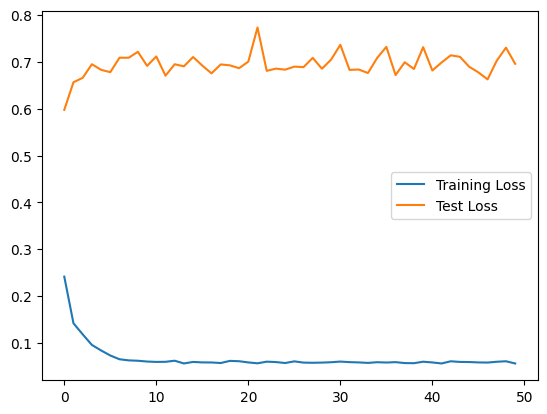

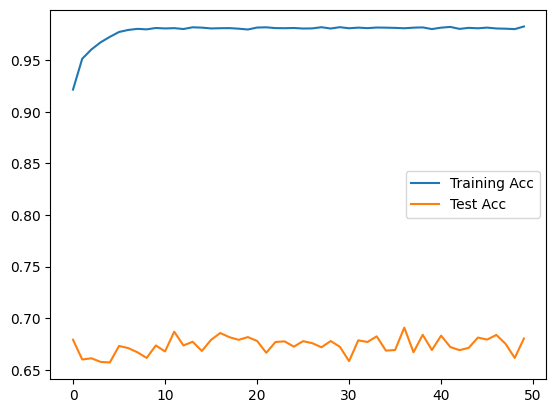

[[3725 1412]
 [1252 2228]]


In [ ]:
# Plot the train and test losses and accuracies
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend()
plt.show()
train_accs = [t.cpu() for t in train_accs]
test_accs = [t.cpu() for t in test_accs]
plt.plot(train_accs, label='Training Acc')
plt.plot(test_accs, label='Test Acc')
plt.legend()
plt.show()

# Get the confusion matrix
y_test = []
y_pred = []
model_ft.eval()
with torch.no_grad():
    for inputs, labels in dataloaders['Test']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)
        y_test.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

conf_mat = confusion_matrix(y_test, y_pred)
print(conf_mat)

# Save the model
torch.save(model_ft.state_dict(), 'fire_classifier_densnet201.pth')

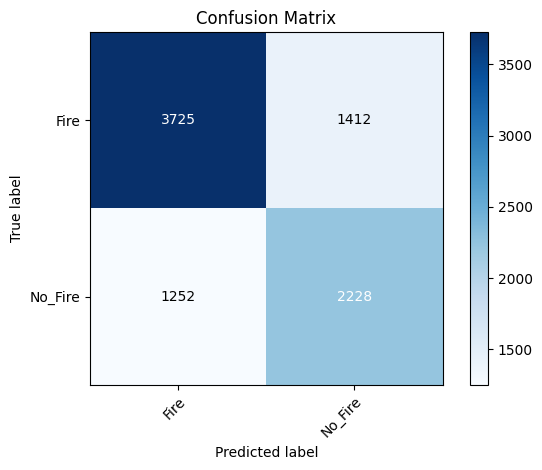

In [ ]:

# Plot the confusion matrix
classes = ['Fire', 'No_Fire']
fig, ax = plt.subplots()
im = ax.imshow(conf_mat, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(conf_mat.shape[1]),
       yticks=np.arange(conf_mat.shape[0]),
       xticklabels=classes, yticklabels=classes,
       title='Confusion Matrix',
       ylabel='True label',
       xlabel='Predicted label')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
fmt = '.2f' if conf_mat.max() < 1 else 'd'
thresh = conf_mat.max() / 2.
for i in range(conf_mat.shape[0]):
    for j in range(conf_mat.shape[1]):
        ax.text(j, i, format(conf_mat[i, j], fmt),
                ha="center", va="center",
                color="white" if conf_mat[i, j] > thresh else "black")
fig.tight_layout()
plt.show()
